In [1]:
using GuidedProposals, DiffusionDefinition, ObservationSchemes
const GP = GuidedProposals
const DD = DiffusionDefinition
const OBS = ObservationSchemes

using StaticArrays, Random, Plots, LinearAlgebra
using Statistics

# seed used for this tutorial
Random.seed!(100)

## data generation ##
@diffusion_process FavettoSamsonModified{T,K} begin
    :dimensions
    process --> 2
    wiener --> 2

    :parameters
    (α, β, λ, μ, σ1, σ2) --> T
    dose --> K

    :additional
    diagdiff --> true
    constdiff --> true
end

DiffusionDefinition.b(t, x, P::FavettoSamsonModified) = @SVector [
    P.α * P.dose(t) - (P.λ +P.β)*x[1] + (P.μ-P.λ)*x[2],
    P.λ*x[1] - (P.μ-P.λ)*x[2]
]

DiffusionDefinition.σ(t, x, P::FavettoSamsonModified) = SDiagonal(P.σ1, P.σ2)

A new struct `FavettoSamsonModified{T, K}` has been defined.


In [2]:
θ = [116.7, 5.83, 1.25, 2.25, 2.0, 1.0]
P_target = FavettoSamsonModified(θ..., t->t/(1+t^2))
tt, y1 = 0.0:0.0001:10.0, @SVector [0.0, 0.0]
X = rand(P_target, tt, y1)

data = map(
    x->(x[1], x[2] + 7randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

data1 = map(
    x->(x[1], x[2][1] + x[2][2] + 7randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

data2 = map(
    x->(x[1], x[2][1] + randn()),
    collect(zip(X.t, X.x))[1:1000:end]
)[2:end]

100-element Vector{Tuple{Float64, Float64}}:
 (0.1, -0.4213782967167186)
 (0.2, 0.145834831616247)
 (0.3, 2.72780956857089)
 (0.4, 2.3811872253780453)
 (0.5, 5.470395496680982)
 (0.6, 5.293457190897906)
 (0.7, 7.9572180853515375)
 (0.8, 8.74119446238982)
 (0.9, 8.24489367367117)
 (1.0, 9.510271271015897)
 (1.1, 8.841895117346132)
 (1.2, 8.975356390335522)
 (1.3, 8.953581408349432)
 ⋮
 (8.9, 1.4869563327454869)
 (9.0, 3.544116579412666)
 (9.1, 1.0839016119643416)
 (9.2, 1.358987662362617)
 (9.3, 0.5162149813355459)
 (9.4, 2.984261957369727)
 (9.5, 3.2659808564424786)
 (9.6, 2.081721761991482)
 (9.7, 2.165358476382616)
 (9.8, 2.5486679787749966)
 (9.9, 1.3284671382653654)
 (10.0, 3.228663031206581)

In [3]:
# let's examine the data
plot(X, Val(:vs_time), size=(800, 300))
scatter!(map(x->x[1], data), map(x->x[2][1], data), label="data")
savefig("simulated_data.png")

In [4]:
recording = (
    #P = FavettoSamsonModified([10, 5, #==# 0.0 #==#, 2, 1, 1]..., t-> 1/(1+t^2)),
    P = FavettoSamsonModified([116.7, 5.83, #==# 1.0 #==#, #==# 2.0 #==#, 2.0, 1.0]..., t->t/(1+t^2)), # diffusion law
    obs = load_data(
        ObsScheme(
            LinearGsnObs(
                0.0, (@SVector [0.0]); # dummy variables indicating datatype of observations
                L=(@SMatrix [1.0 1.0]), # observation operator
                Σ=(@SMatrix [7]) #1e-2*SDiagonal{2,Float64}(I) # noise on the observations
            )
        ),
        data1
    ),
    t0 = 0.0,
    x0_prior = KnownStartingPt(y1),
)

(P = FavettoSamsonModified{Float64, var"#13#14"}(116.7, 5.83, 1.0, 2.0, 2.0, 1.0, var"#13#14"()), obs = LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Int64, 1}, Any}[LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Int64, 1}, Any}([1.0 1.0], [0.0], [7], [5.012547309810912], 0.1, false, Any[]), LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Int64, 1}, Any}([1.0 1.0], [0.0], [7], [5.687127983464942], 0.2, false, Any[]), LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Int64, 1}, Any}([1.0 1.0], [0.0], [7], [-0.8746210577075479], 0.3, false, Any[]), LinearGsnObs{0, 1, SVector{1, Float64}, NoFirstPassageTimes, SMatrix{1, 2, Float64, 2}, SVector{1, Float64}, SMatrix{1, 1, Int64, 1}, Any}([1.0 1.

In [5]:
@diffusion_process FavettoSamsonAux{K,Q,R} begin
    :dimensions
    process --> 2
    wiener --> 2

    :parameters
    (α, β, λ, μ, σ1, σ2) --> K
    dose --> Q
    :auxiliary_info
    t0 --> Float64
    T --> Float64
    vT --> R

    :additional
    constdiff --> true
    linear --> true
end

DiffusionDefinition.B(t, P::FavettoSamsonAux) = @SMatrix [-(P.λ+ P.β) P.β; P.λ -P.μ]
DiffusionDefinition.β(t, P::FavettoSamsonAux) = @SVector [P.α* P.dose(t), 0.0]
DiffusionDefinition.σ(t, P::FavettoSamsonAux) = SDiagonal(P.σ1, P.σ2)

@load_diffusion FavettoSamsonAux

A new struct `FavettoSamsonAux{K, Q, R}` has been defined.


In [6]:
"""
Adaptive readjustment for the `i`th recording of the preconditioned
Crank–Nicolson scheme's memory parameter.
"""
max_p, min_p = 1e7, 1e-12
target_rate = 0.44
# define a time delay
offset = 9.6

function readjust(p_old, accpt_r, δ, mcmc_iter)
    p = sigmoid(logit(p_old)-(2*(accpt_r > target_rate)-1)* δ)
    p = max.(min.(p,  max_p), min_p)
end

sigmoid(x, a=1.0) = 1.0 / (1.0 + exp(-a*x))
logit(x, a=1.0) = (log(x) - log(1-x))/a

"""
    compute_δ(p, mcmc_iter)
δ decreases roughly proportional to scale/sqrt(iteration)
"""
function compute_δ(mcmc_iter)
    1.0 / sqrt(
        max(1.0, mcmc_iter/100 -offset)
    )
end

compute_δ

In [7]:
# define a transition kernel for θ
function customkernel(θ, s1::Symbol, s2::Symbol,scale=0.1)
	θ° = deepcopy(θ)
	θ°[s1] += 2.0*scale*(rand()-0.5)
    θ°[s2] += 2.0*scale*(rand()-0.5)
	θ°
end

customkernel (generic function with 2 methods)

In [8]:
function GaussianRandomWalk(Σ, pos=nothing)
    @assert size(Σ, 1) == size(Σ, 2)
    Σ = reshape(Σ, (size(Σ, 1), size(Σ, 2)))
     T = eltype(Σ)
    pos = (pos === nothing) ? fill(false, size(Σ, 1)) : pos
    new{T}(Symmetric(Σ), pos)
end

GaussianRandomWalk (generic function with 2 methods)

In [9]:
function simple_inference(AuxLaw, recording, dt, θ, s1::Symbol, s2::Symbol; ρ=0.5, q=0.2, num_steps=10^4)
	# initializations
	tts = OBS.setup_time_grids(recording, dt)
	PP = build_guid_prop(AuxLaw, recording, tts)
	PP° = deepcopy(PP)

	y1 = rand(recording.x0_prior) # just returns the starting point
	XX, WW, Wnr = rand(PP, y1)
	XX°, WW° = trajectory(PP)

	ll = loglikhd(PP, XX)
	paths = []
	θθ1 = Float64[θ[s1],]
    θθ2 = Float64[θ[s2],]
    θθ = Float64[θ[s1]/(θ[s2]-θ[s1]),]
#     θθ = Float64[θ[s1]/θ[s2],]
#     p_list = Float64[θ[s],]
#     p_mean = θ[s]
#     ssq = p_mean^2
	imp_a_r = 0
	param_a_r = 0

	# MCMC
	for i in 1:num_steps
		# impute a path
		_, ll° = rand!(PP, XX°, WW°, WW, ρ, Val(:ll), y1; Wnr=Wnr)

		if rand() < exp(ll°-ll)
			XX, WW, XX°, WW° = XX°, WW°, XX, WW
			ll = ll°
			imp_a_r += 1
		end

		# update parameter
        θ° = customkernel(θ, s1, s2, q)
		DD.set_parameters!(PP°, θ°)
		recompute_guiding_term!(PP°)
		_, ll° = GP.solve_and_ll!(XX°, WW, PP°, y1)

		if rand() < exp(ll°-ll) # uniform updates have no contribution to ll
			XX, PP, θ, XX°, PP°, θ° = XX°, PP°, θ°, XX, PP, θ
			ll = ll°
			param_a_r += 1
		end
		append!(θθ1, [θ[s1]])
        append!(θθ2, [θ[s2]])
        append!(θθ, [θ[s1]/(θ[s2]-θ[s1])])
#         append!(θθ, [θ[s1]/θ[s2]])
#         append!(p_list, [θ[s]])


		# progress message
		if i % 100 == 0
			println(
				"$i. ll=$ll, estimate=$(θ[s1]),$(θ[s2]), imp accpt rate: $(imp_a_r/100), ",
				"updt accpt rate: $(param_a_r/100)"
			)
            accpt_r = imp_a_r / 100
#             accpt_r = param_a_r/100
            δ = compute_δ(i)
            ρ = readjust(ρ, accpt_r, δ, i)
			imp_a_r = param_a_r = 0
            
            # now update transition kernel q
#             d = length(p_list)
#             p_mean = p_mean * d / (d+1) + θ[:λ] / (d+1)
#             ssq += θ[:λ]^2 / d
#             v = ssq - (d+1) / d * p_mean^2
#             q = 2.38^2 / d * v
#             p_list = []
            
		end

		# save intermediate path for plotting
		i % 400 == 0 && append!(paths, [deepcopy(XX)])
	end
	paths, θθ
end

simple_inference (generic function with 1 method)

In [10]:
# let's declare which parameters are not changing
DD.const_parameter_names(::Type{<:FavettoSamsonModified}) = (:α, :β,:σ1, :σ2) 
DD.const_parameter_names(::Type{<:FavettoSamsonAux}) = (:α, :β, :σ1, :σ2, :t0, :T, :vT, :xT)
# and do the inference
# paths, θθ= simple_inference(
# 	FavettoSamsonAux, recording, 0.02, Dict( :α=> 100.0, :β=> 2.0), :α, :β; ρ= 0.5, q=0.2, num_steps= 10^4
# ) 
paths, θθ= simple_inference(
	FavettoSamsonAux, recording, 0.02, Dict( :λ=> 1.0, :μ=> 2.0), :λ, :μ; ρ= 0.5, q=0.2, num_steps= 10^4
) 

100. ll=-494.2765358059844, estimate=1.588775233539613,3.086900363485949, imp accpt rate: 0.15, updt accpt rate: 0.44
200. ll=-487.2330969316569, estimate=1.2489958841561322,2.1792209748269613, imp accpt rate: 0.15, updt accpt rate: 0.41
300. ll=-486.6993291793727, estimate=1.4143460263697154,2.58391294098655, imp accpt rate: 0.43, updt accpt rate: 0.46
400. ll=-483.65063374828776, estimate=1.5251818716793242,2.9281909170606943, imp accpt rate: 0.52, updt accpt rate: 0.45
500. ll=-482.592554599025, estimate=1.1580703775022367,2.126619156651892, imp accpt rate: 0.24, updt accpt rate: 0.51
600. ll=-480.93771621991095, estimate=1.0125388452467843,1.851487453327079, imp accpt rate: 0.34, updt accpt rate: 0.34
700. ll=-480.7324072578739, estimate=1.191203031561055,2.2446026924221427, imp accpt rate: 0.61, updt accpt rate: 0.34
800. ll=-486.5645586391388, estimate=1.5405001528992746,2.86175712186069, imp accpt rate: 0.47, updt accpt rate: 0.49
900. ll=-491.75081353876413, estimate=1.45076644

6900. ll=-492.6154542764913, estimate=2.6937706189694297,5.08015090912222, imp accpt rate: 0.42, updt accpt rate: 0.61
7000. ll=-486.34499469972087, estimate=3.2847580450235534,5.969694828526112, imp accpt rate: 0.36, updt accpt rate: 0.63
7100. ll=-488.85285500231475, estimate=3.6827615527873507,6.879342799057789, imp accpt rate: 0.14, updt accpt rate: 0.57
7200. ll=-489.59136250378396, estimate=3.9164941603601093,7.116719839422549, imp accpt rate: 0.18, updt accpt rate: 0.64
7300. ll=-492.4332661420035, estimate=3.659716611223151,6.960303977377608, imp accpt rate: 0.4, updt accpt rate: 0.6
7400. ll=-486.7382753360014, estimate=3.7305456750353434,6.496700051125186, imp accpt rate: 0.36, updt accpt rate: 0.66
7500. ll=-490.9218512285138, estimate=3.4721415016757193,6.417876319993739, imp accpt rate: 0.45, updt accpt rate: 0.56
7600. ll=-485.9498983272443, estimate=3.6384204869245726,6.553455618057153, imp accpt rate: 0.42, updt accpt rate: 0.64
7700. ll=-485.9667036282525, estimate=3.7

(Any[Trajectory{Vector{Float64}, Vector{SVector{2, Float64}}}[Trajectory{Vector{Float64}, Vector{SVector{2, Float64}}}([0.0, 0.02, 0.04, 0.06, 0.08, 0.1], SVector{2, Float64}[[0.0, 0.0], [0.06410788524980754, -0.15246994958401072], [0.002937309178103753, -0.3828675894686211], [0.2562842254667784, -0.6456178253459037], [0.7473171601542855, -0.6060857658909997], [1.1292448068151655, -0.6040289569080897]]), Trajectory{Vector{Float64}, Vector{SVector{2, Float64}}}([0.1, 0.12, 0.14, 0.16, 0.18, 0.2], SVector{2, Float64}[[1.1292448068151655, -0.6040289569080897], [1.5653662079592485, -0.5309882396531035], [1.3972007581054287, -0.4311263331435849], [1.8923051140701608, -0.5316507269695947], [1.6350579386777966, -0.5339934509625102], [1.578257433976265, -0.3078181478965511]]), Trajectory{Vector{Float64}, Vector{SVector{2, Float64}}}([0.2, 0.22, 0.24, 0.26, 0.28, 0.3], SVector{2, Float64}[[1.578257433976265, -0.3078181478965511], [1.5119696654231634, -0.24609332767635894], [1.7757005545828828, 

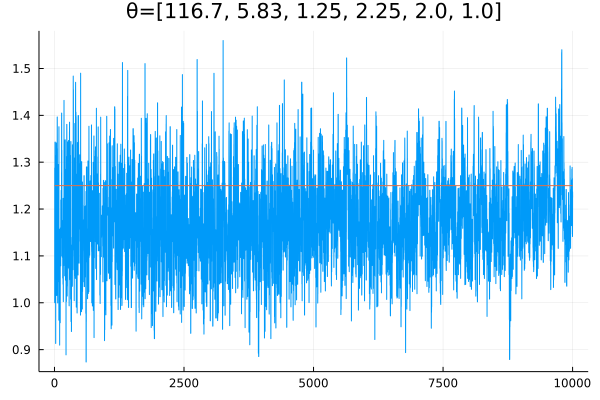

In [12]:
p1 = plot(θθ, title = "θ=[116.7, 5.83, 1.25, 2.25, 2.0, 1.0]",label="")
plot!(θθ-> 1.25,label="")
display(p1)
savefig("infer_λ_μ_ratio.png")